In [2]:
# Importing libraries
"""
Here, we have imported various libraries such as numpy, pandas, torch and torchvision for
image processing and machine learning tasks. It also sets the seed for reproducibility and sets
the device for computation (cuda or cpu).
"""

import os
import random
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision.io import read_image
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms

# Initital configurations
SEED = 1234

def set_seeds(seed=1234):
    """Set seeds for reproducibility."""
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # multi-GPU

# Set seeds for reproducibility
set_seeds(seed=SEED)

# Set device
cuda = True
device = torch.device("cuda" if (
    torch.cuda.is_available() and cuda) else "cpu")

print(device)

cuda


In [3]:
pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 19.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-

In [4]:
# Mount Google Drive
from google.colab import drive
import zipfile

drive.mount('/content/drive')

# Specify the paths to the zip files in Google Drive
aspeg_norm_zip_path = '/content/drive/MyDrive/CPA_2.zip'
normal_zip_path = '/content/drive/MyDrive/Normal.zip'

# Extract the ASPEG_NORM.zip file
with zipfile.ZipFile(aspeg_norm_zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/datasets/CPA')

# Extract the Normal.zip file
with zipfile.ZipFile(normal_zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/datasets/Normal')

Mounted at /content/drive


In [5]:
from google.colab import drive
import os

# Mount Google Drive

# Path to the directories
aspeg_norm_dir = '/content/datasets/CPA'
normal_pics_dir = '/content/datasets/Normal'

# List of directories
directories = [aspeg_norm_dir, normal_pics_dir]

# Dictionary to store the count of files in each directory
file_counts = {}

# Iterate over each directory
for directory in directories:
    # Initialize the count for the current directory
    file_count = 0

    # Iterate over each file in the directory
    for root, _, files in os.walk(directory):
        # Increment the count by the number of files in the current directory
        file_count += len(files)

    # Store the count in the dictionary
    file_counts[directory] = file_count

# Print the count of files in each directory
print("Number of files in each directory:")
for directory, count in file_counts.items():
    print(f"{directory}: {count}")


Number of files in each directory:
/content/datasets/CPA: 1410
/content/datasets/Normal: 3500


In [25]:
import glob
import random
import shutil
from sklearn.model_selection import train_test_split

# Verify the extracted files
normal = glob.glob("/content/datasets/Normal/Normal/*")
cpa = glob.glob("/content/datasets/CPA/CPA/*")

assert len(normal) >= 80, f"Expected 80 images in Normal, but found {len(normal)}"
assert len(cpa) >= 80, f"Expected 80 images in CPA, but found {len(cpa)}"

# Combine all images and labels
all_images = normal + cpa
all_labels = [0] * len(normal) + [1] * len(cpa)

# Split the dataset into train, validation, and test sets with stratification
train_imgs, temp_imgs, train_labels, temp_labels = train_test_split(
    all_images, all_labels, stratify=all_labels, test_size=0.3, random_state=SEED)

val_imgs, test_imgs, val_labels, test_labels = train_test_split(
    temp_imgs, temp_labels, stratify=temp_labels, test_size=0.5, random_state=SEED)

# Combine and shuffle the datasets
train_path = train_imgs
val_path = val_imgs
test_path = test_imgs

random.shuffle(train_path)
random.shuffle(val_path)
random.shuffle(test_path)

# Output the sizes of each dataset
print("-------------------Dataset------------------")
print("Total train CXR Images: ", len(train_path))
print("Total val CXR Images: ", len(val_path))
print("Total test CXR Images: ", len(test_path))

# Optional: move files to their respective directories (train, val, test)
for category, paths in zip(['train', 'val', 'test'], [train_path, val_path, test_path]):
    os.makedirs(f'/content/datasets/{category}/Normal', exist_ok=True)
    os.makedirs(f'/content/datasets/{category}/CPA', exist_ok=True)

    for img_path in paths:
        label = 'Normal' if 'Normal' in img_path else 'CPA'
        shutil.copy(img_path, f'/content/datasets/{category}/{label}/{os.path.basename(img_path)}')


-------------------Dataset------------------
Total train CXR Images:  2950
Total val CXR Images:  632
Total test CXR Images:  633


In [27]:
from torchvision import transforms

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'others': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [28]:
class ASP_CXR_Dataset(Dataset):
    def __init__(self, images, transform=None):
        self.img_paths = images
        self.img_labels = [0 if "Normal" in img else 1 for img in self.img_paths]
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        label = self.img_labels[idx]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label

train_data = ASP_CXR_Dataset(train_path, transform=data_transforms["train"])
valid_data = ASP_CXR_Dataset(val_path, transform=data_transforms["others"])
test_data = ASP_CXR_Dataset(test_path, transform=data_transforms["others"])

train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
valid_dataloader = DataLoader(valid_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=True)

# Verify the dataloaders
data, labels = next(iter(train_dataloader))
print("Batch labels in train_dataloader:", labels)

data, labels = next(iter(valid_dataloader))
print("Batch labels in valid_dataloader:", labels)

data, labels = next(iter(test_dataloader))
print("Batch labels in test_dataloader:", labels)

Batch labels in train_dataloader: tensor([0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0])
Batch labels in valid_dataloader: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        1, 0, 0, 0, 0, 0, 1, 0])
Batch labels in test_dataloader: tensor([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])


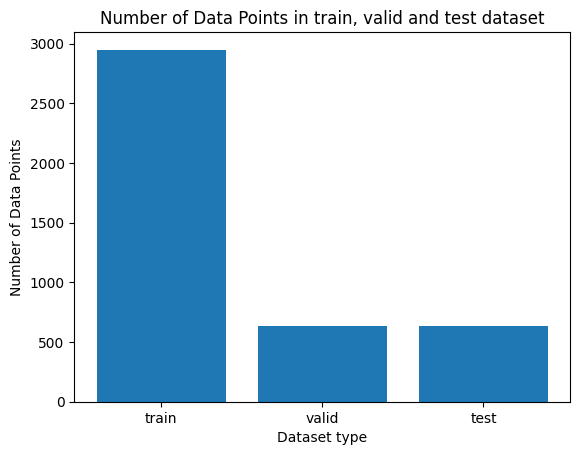

In [29]:
# Get the number of data points in each dataset
train_size = len(train_data)
valid_size = len(valid_data)
test_size = len(test_data)

# Create a list of the sizes of each dataset
sizes = [train_size, valid_size, test_size]

# Create a bar plot with the sizes of the datasets
plt.bar(['train', 'valid', 'test'], sizes)

# Add labels and title to the plot
plt.xlabel('Dataset type')
plt.ylabel('Number of Data Points')
plt.title('Number of Data Points in train, valid and test dataset')

# Show the plot
plt.show()

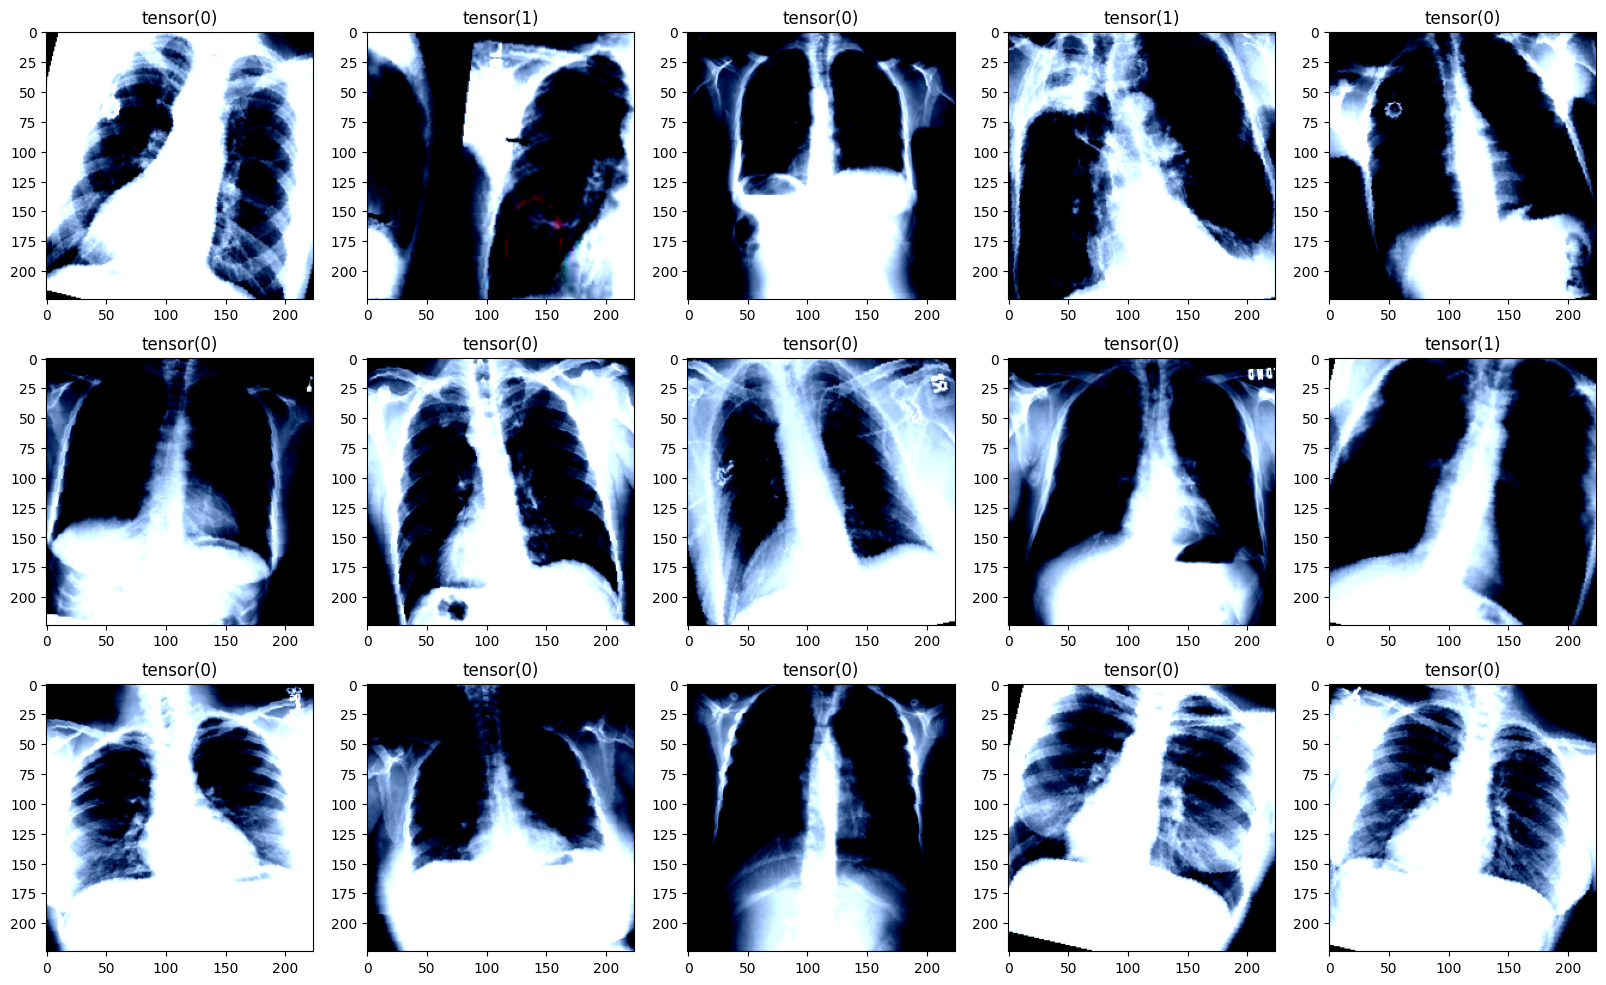

In [30]:
# Load your data using a PyTorch dataloader
data, labels = next(iter(train_dataloader))

# Create a figure with a grid of subplots
fig, axs = plt.subplots(nrows=3, ncols=5,figsize=(20, 12))

# Plot the images in the subplots
for i, ax in enumerate(axs.flat):
    # Get the image and label for the current subplot
    image, label = data[i], labels[i]

    # Convert the image to a numpy array and plot it
    img = image.numpy().transpose((1, 2, 0))
    # mean = np.array([0.485, 0.456, 0.406])
    # std = np.array([0.229, 0.224, 0.225])
    # img = std * img + mean
    img = np.clip(img, 0, 1)

    ax.imshow(img)

    # Set the title of the subplot to the label
    ax.set_title(label)

# Show the plot
plt.show()

In [31]:
from torchvision.models import densenet121,DenseNet121_Weights, DenseNet

#model architecture
class CXR_DenseNetModel(nn.Module):
  """DenseNet121 pretrained model definition."""
  def __init__(self, num_classes):
      super(CXR_DenseNetModel, self).__init__()

      self.model = torchvision.models.densenet121(pretrained=True)

      # Freeze the model's parameters
      for param in self.model.parameters():
          param.requires_grad = False

      # Replace the last linear layer of the model
      in_features = self.model.classifier.in_features
      self.model.classifier = nn.Sequential(
          nn.Linear(in_features, in_features // 2),
          nn.Dropout(0.5),
          nn.Linear(in_features // 2, in_features // 4),
          # nn.Dropout(0.5),
          nn.Linear(in_features // 4, in_features // 8),
          nn.Dropout(0.25),
          nn.Linear(in_features // 8, num_classes),
      )

  def forward(self, x):
      return self.model(x)

model = CXR_DenseNetModel(num_classes=2)


# set device
model = model.to(device)
model


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


CXR_DenseNetModel(
  (model): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, mome

In [32]:
# calculating weights for each classes

def class_weight(x,total):
  return 1 - (x/total)

total = 2625 + 1057
class_weights = torch.tensor([class_weight(2625,total),class_weight(1057,total)])

In [33]:
# Define the Binary CrossEntropy with Logits loss function and Adam optimizer
loss_fn = nn.BCEWithLogitsLoss(weight = class_weights.to(device))
optimizer = optim.Adam(model.parameters(),lr=0.001)

# Decay LR by a factor of 0.1 every 3 epochs
# scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [ ]:
from tqdm import tqdm
train_losses = []
valid_losses = []
train_acc = []
valid_acc=[]
# Define a function for the training loop
def train(model, loss_fn, optimizer, num_epochs):

    for epoch in tqdm(range(num_epochs)):

        # Training
        # Set the model to training mode
        model.train()

        train_size = 0
        train_loss = 0.0
        train_accuracy = 0.0

        # Loop through the training dataloader
        for batch_idx, (images, labels) in enumerate(train_dataloader):
            images, labels = images.to(device), labels.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = loss_fn(outputs, F.one_hot(labels,2).float())

            # Compute accuracy
            _, preds = torch.max(outputs, 1)
            train_accuracy += torch.sum(preds == labels.data)

            # Backward pass
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            train_size += images.size(0)

        # Validation
        # Set the model to evalutaion mode
        model.eval()

        valid_size = 0
        valid_loss = 0.0
        valid_accuracy = 0.0

        # Loop through the validing dataloader
        for batch_idx, (images, labels) in enumerate(valid_dataloader):
            images, labels = images.to(device), labels.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = loss_fn(outputs, F.one_hot(labels,2).float())

            # Compute accuracy
            _, preds = torch.max(outputs, 1)
            valid_accuracy += torch.sum(preds == labels.data)

            # Backward pass
            loss.backward()
            optimizer.step()

            valid_loss += loss.item() * images.size(0)
            valid_size += images.size(0)

        # Print training and validation statistics
        train_loss = train_loss / train_size
        train_losses.append(train_loss)
        train_accuracy = train_accuracy / train_size
        train_acc.append(train_accuracy)

        valid_loss = valid_loss / valid_size
        valid_losses.append(valid_loss)

        valid_accuracy = valid_accuracy / valid_size
        valid_acc.append(valid_accuracy)


        print(f"\nTrain Loss: {train_loss:.3f},Train Accuracy: {train_accuracy:.3f}, Valid Loss: {valid_loss:.3f}, Valid Accuracy: {valid_accuracy:.2f}")

# Train the model
train(model, loss_fn, optimizer, num_epochs=25)

  4%|▍         | 1/25 [00:48<19:34, 48.93s/it]


Train Loss: 0.082,Train Accuracy: 0.933, Valid Loss: 0.024, Valid Accuracy: 0.99


  8%|▊         | 2/25 [01:36<18:28, 48.19s/it]


Train Loss: 0.019,Train Accuracy: 0.988, Valid Loss: 0.004, Valid Accuracy: 1.00


 12%|█▏        | 3/25 [02:25<17:42, 48.31s/it]


Train Loss: 0.023,Train Accuracy: 0.987, Valid Loss: 0.005, Valid Accuracy: 1.00


 16%|█▌        | 4/25 [03:12<16:48, 48.01s/it]


Train Loss: 0.020,Train Accuracy: 0.985, Valid Loss: 0.001, Valid Accuracy: 1.00


 20%|██        | 5/25 [04:00<16:01, 48.10s/it]


Train Loss: 0.005,Train Accuracy: 0.997, Valid Loss: 0.000, Valid Accuracy: 1.00


 24%|██▍       | 6/25 [04:48<15:13, 48.09s/it]


Train Loss: 0.014,Train Accuracy: 0.989, Valid Loss: 0.009, Valid Accuracy: 0.99


 28%|██▊       | 7/25 [05:36<14:25, 48.08s/it]


Train Loss: 0.008,Train Accuracy: 0.995, Valid Loss: 0.000, Valid Accuracy: 1.00


 32%|███▏      | 8/25 [06:25<13:39, 48.22s/it]


Train Loss: 0.012,Train Accuracy: 0.991, Valid Loss: 0.006, Valid Accuracy: 1.00


 36%|███▌      | 9/25 [07:13<12:49, 48.11s/it]


Train Loss: 0.006,Train Accuracy: 0.996, Valid Loss: 0.001, Valid Accuracy: 1.00


 40%|████      | 10/25 [08:02<12:05, 48.34s/it]


Train Loss: 0.006,Train Accuracy: 0.996, Valid Loss: 0.000, Valid Accuracy: 1.00


 44%|████▍     | 11/25 [08:49<11:13, 48.13s/it]


Train Loss: 0.015,Train Accuracy: 0.991, Valid Loss: 0.029, Valid Accuracy: 1.00


 48%|████▊     | 12/25 [09:38<10:28, 48.38s/it]


Train Loss: 0.009,Train Accuracy: 0.995, Valid Loss: 0.000, Valid Accuracy: 1.00


 52%|█████▏    | 13/25 [10:26<09:38, 48.23s/it]


Train Loss: 0.006,Train Accuracy: 0.996, Valid Loss: 0.000, Valid Accuracy: 1.00


 56%|█████▌    | 14/25 [11:15<08:51, 48.35s/it]


Train Loss: 0.010,Train Accuracy: 0.994, Valid Loss: 0.000, Valid Accuracy: 1.00


 60%|██████    | 15/25 [12:04<08:05, 48.56s/it]


Train Loss: 0.006,Train Accuracy: 0.997, Valid Loss: 0.003, Valid Accuracy: 1.00


 64%|██████▍   | 16/25 [12:53<07:18, 48.68s/it]


Train Loss: 0.008,Train Accuracy: 0.994, Valid Loss: 0.030, Valid Accuracy: 0.98


 68%|██████▊   | 17/25 [13:41<06:27, 48.45s/it]


Train Loss: 0.052,Train Accuracy: 0.981, Valid Loss: 0.023, Valid Accuracy: 0.98


 72%|███████▏  | 18/25 [14:29<05:39, 48.46s/it]


Train Loss: 0.037,Train Accuracy: 0.988, Valid Loss: 0.001, Valid Accuracy: 1.00


 76%|███████▌  | 19/25 [15:18<04:52, 48.68s/it]


Train Loss: 0.009,Train Accuracy: 0.993, Valid Loss: 0.000, Valid Accuracy: 1.00


 80%|████████  | 20/25 [16:07<04:03, 48.61s/it]


Train Loss: 0.007,Train Accuracy: 0.996, Valid Loss: 0.000, Valid Accuracy: 1.00


 84%|████████▍ | 21/25 [16:55<03:14, 48.54s/it]


Train Loss: 0.004,Train Accuracy: 0.998, Valid Loss: 0.001, Valid Accuracy: 1.00


 88%|████████▊ | 22/25 [17:43<02:25, 48.41s/it]


Train Loss: 0.009,Train Accuracy: 0.996, Valid Loss: 0.000, Valid Accuracy: 1.00


 92%|█████████▏| 23/25 [18:32<01:36, 48.37s/it]


Train Loss: 0.008,Train Accuracy: 0.995, Valid Loss: 0.000, Valid Accuracy: 1.00


 96%|█████████▌| 24/25 [19:21<00:48, 48.77s/it]


Train Loss: 0.003,Train Accuracy: 0.997, Valid Loss: 0.000, Valid Accuracy: 1.00


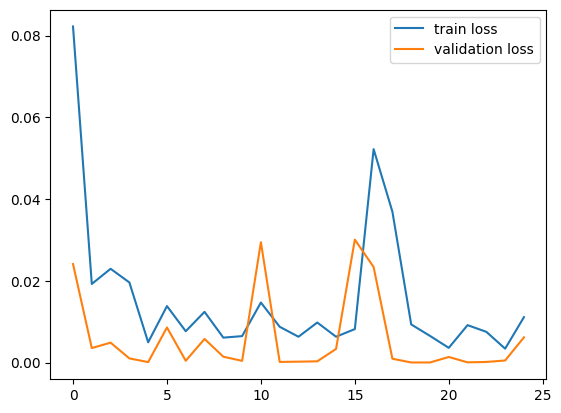

In [16]:
# plot train and test losses
plt.plot(train_losses, label='train loss')
plt.plot(valid_losses, label='validation loss')
plt.legend()
plt.show()

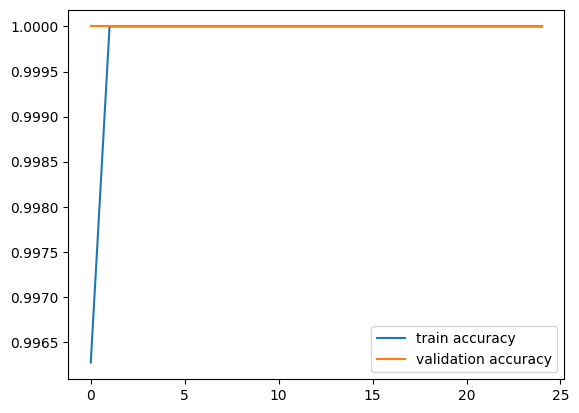

In [17]:
# plot train and test acc
train_acc_np= np.array([x.cpu().numpy() for x in train_acc])
valid_acc_np= np.array([x.cpu().numpy() for x in valid_acc])

plt.plot(train_acc_np, label='train accuracy')
plt.plot(valid_acc_np, label='validation accuracy')
plt.legend()
plt.show()